# Author: Bradley Hull
# Project: Finding the minimum number of hours needed to predict whether a storm is a hurricane or tropical storm on hour 78.
| Models Used                   |
|-------------------------------|
| Naive Bayes                   |
| Logistic Regression (tuned)   |
| Decision Tree                 |
| Decision Tree (ccp)           |
| XGBoost (tuned)               |
| Random Forest (tuned)         |


# Data Preprocessing

In [92]:
import pandas as pd
import numpy as np
from geopy import distance

In [93]:
dataset = "hurdat2-atl-02052024.txt"
initial_df = pd.read_csv(dataset, header=None, sep='|')
initial_df.head()

,0
0,"AL011851, UNNAMED, 14,"
1,"18510625, 0000, , HU, 28.0N, 94.8W, 80, -99..."
2,"18510625, 0600, , HU, 28.0N, 95.4W, 80, -99..."
3,"18510625, 1200, , HU, 28.0N, 96.0W, 80, -99..."
4,"18510625, 1800, , HU, 28.1N, 96.5W, 80, -99..."


In [94]:
storms = {}
header = None
for line in initial_df[0]:
    tokens = line.split(',')
    if len(tokens) == 4:
        header = line
        storms[header] = []
    elif len(tokens) == 21:
        row = [token.strip() for token in tokens]
        storms[header].append(row)

In [95]:
frames = []

for storm_id, storm in enumerate(storms):
    code, name, entries, blank = [record.strip() for record in storm.split(',')]
    if int(entries) <= 12:
        continue
    basic_columns = {
        'BASIN': code[:2],
        'ATCF_CY_NUMBER': code[2:4],
        'YEAR': code[4:9],
        'NAME': name,
        'NUM_BEST_TRACK_ENTRIES': entries,
        'ID': storm_id
    }
    dataset = pd.DataFrame(storms[storm], columns = [
                                                'DATE',
                                                'TIME_UTC',
                                                'POINT_TYPE',
                                                'STATUS',
                                                'LATITUDE',
                                                'LONGITUDE',
                                                'MAX_WINDSPEED_KT',
                                                'MIN_PRESURE_MB',
                                                'NE_34KT',
                                                'SE_34KT',
                                                'NW_34_KT',
                                                'SW_34_KT',
                                                'NE_50KT',
                                                'SE_50KT',
                                                'NW_50_KT',
                                                'SW_50_KT',
                                                'NE_64KT',
                                                'SE_64KT',
                                                'NW_64_KT',
                                                'SW_64_KT',
                                                'RADIUS'
                                                    ])
    
    for column in basic_columns:
        dataset[column] = basic_columns[column]
    frames.append(dataset)

final_df = pd.concat(frames)

In [96]:
def convertHemisphericLat(latitude):
    latval = 0
    if ('N' in latitude):
        latitude = latitude.strip('N')
        latval = float(latitude)
    elif ('S' in latitude):
        latitude = latitude.strip('S')
        latitude = float(latitude)
        latval = -latitude
    return latval

def convertHemisphericLong(longitude):
    longval = 0
    if ('E' in longitude):
        longitude = longitude.strip('E')
        longval = float(longitude)
    elif ('W' in longitude):
        longitude = longitude.strip('W')
        longitude = float(longitude)
        longval = -longitude
    return longval

final_df['LATITUDE'] = final_df['LATITUDE'].apply(lambda lat: convertHemisphericLat(lat))
final_df['LONGITUDE'] = final_df['LONGITUDE'].apply(lambda long: convertHemisphericLong(long))
final_df.head()

,DATE,TIME_UTC,POINT_TYPE,STATUS,LATITUDE,LONGITUDE,MAX_WINDSPEED_KT,MIN_PRESURE_MB,NE_34KT,SE_34KT,...,SE_64KT,NW_64_KT,SW_64_KT,RADIUS,BASIN,ATCF_CY_NUMBER,YEAR,NAME,NUM_BEST_TRACK_ENTRIES,ID
0,18510625,0000,,HU,28.0,-94.8,80,-999,-999,-999,...,-999,-999,-999,-999,AL,01,1851,UNNAMED,14,0
1,18510625,0600,,HU,28.0,-95.4,80,-999,-999,-999,...,-999,-999,-999,-999,AL,01,1851,UNNAMED,14,0
2,18510625,1200,,HU,28.0,-96.0,80,-999,-999,-999,...,-999,-999,-999,-999,AL,01,1851,UNNAMED,14,0
3,18510625,1800,,HU,28.1,-96.5,80,-999,-999,-999,...,-999,-999,-999,-999,AL,01,1851,UNNAMED,14,0
4,18510625,2100,L,HU,28.2,-96.8,80,-999,-999,-999,...,-999,-999,-999,-999,AL,01,1851,UNNAMED,14,0


## these columns had too much missing data

In [97]:
final_df = final_df.drop(columns=['POINT_TYPE', 'BASIN'])

In [98]:
final_df['DATE'] = final_df['DATE'].astype(int)
final_df['TIME_UTC'] = final_df['TIME_UTC'].astype(int)
final_df['MAX_WINDSPEED_KT'] = final_df['MAX_WINDSPEED_KT'].astype(int)
final_df['MIN_PRESURE_MB'] = final_df['MIN_PRESURE_MB'].astype(int)
final_df['NUM_BEST_TRACK_ENTRIES'] = final_df['NUM_BEST_TRACK_ENTRIES'].astype(int)
final_df['NE_34KT'] = final_df['NE_34KT'].astype(int)
final_df['SE_34KT'] = final_df['SE_34KT'].astype(int)
final_df['NW_34_KT'] = final_df['NW_34_KT'].astype(int)
final_df['SW_34_KT'] = final_df['SW_34_KT'].astype(int)
final_df['NE_50KT'] = final_df['NE_50KT'].astype(int)
final_df['SE_50KT'] = final_df['SE_50KT'].astype(int)
final_df['NW_50_KT'] = final_df['NW_50_KT'].astype(int)
final_df['SW_50_KT'] = final_df['SW_50_KT'].astype(int)
final_df['NE_64KT'] = final_df['NE_64KT'].astype(int)
final_df['SE_64KT'] = final_df['SE_64KT'].astype(int)
final_df['NW_64_KT'] = final_df['NW_64_KT'].astype(int)
final_df['SW_64_KT'] = final_df['SW_64_KT'].astype(int)
final_df['RADIUS'] = final_df['RADIUS'].astype(int)
final_df['YEAR'] = final_df['YEAR'].astype(int)
final_df['ATCF_CY_NUMBER'] = final_df['ATCF_CY_NUMBER'].astype(int)


In [99]:
final_df.dtypes

DATE                        int32
TIME_UTC                    int32
STATUS                     object
LATITUDE                  float64
LONGITUDE                 float64
MAX_WINDSPEED_KT            int32
MIN_PRESURE_MB              int32
NE_34KT                     int32
SE_34KT                     int32
NW_34_KT                    int32
SW_34_KT                    int32
NE_50KT                     int32
SE_50KT                     int32
NW_50_KT                    int32
SW_50_KT                    int32
NE_64KT                     int32
SE_64KT                     int32
NW_64_KT                    int32
SW_64_KT                    int32
RADIUS                      int32
ATCF_CY_NUMBER              int32
YEAR                        int32
NAME                       object
NUM_BEST_TRACK_ENTRIES      int32
ID                          int64
dtype: object

In [100]:
final_df['STATUS'].value_counts()



STATUS
TS    18781
HU    15053
TD     8437
EX     5926
LO     1462
SS      635
SD      292
DB      250
WV      138
Name: count, dtype: int64

In [101]:
final_df['NUM_BEST_TRACK_ENTRIES'].value_counts()

NUM_BEST_TRACK_ENTRIES
39    1560
22    1408
21    1281
20    1260
33    1254
      ... 
87      87
85      85
84      84
78      78
76      76
Name: count, Length: 81, dtype: int64

In [102]:
status_map = {
    'TS': 0,
    'HU': 1,
    'TD': 2,
    'EX': 3,
    'LO': 4,
    'SS': 5,
    'SD': 6,
    'DB': 7,
    'WV': 8
}

# converting the status col to numerical values
final_df['STATUS'] = final_df['STATUS'].map(status_map)
final_df['STATUS']

0     1
1     1
2     1
3     1
4     1
     ..
21    0
22    0
23    2
24    2
25    4
Name: STATUS, Length: 50974, dtype: int64

In [103]:
# unneeded cols
final_df = final_df.drop(columns=['NAME', 'DATE', 'ATCF_CY_NUMBER'])

## Years < 1975 don't have pressure readings

In [104]:
final_df = final_df[final_df['YEAR'] > 1975]
final_df

,TIME_UTC,STATUS,LATITUDE,LONGITUDE,MAX_WINDSPEED_KT,MIN_PRESURE_MB,NE_34KT,SE_34KT,NW_34_KT,SW_34_KT,...,NW_50_KT,SW_50_KT,NE_64KT,SE_64KT,NW_64_KT,SW_64_KT,RADIUS,YEAR,NUM_BEST_TRACK_ENTRIES,ID
0,1200,6,24.0,-89.0,20,1010,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,1976,18,1186
1,1800,6,24.8,-89.6,20,1009,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,1976,18,1186
2,0,6,25.4,-90.0,25,1006,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,1976,18,1186
3,600,6,26.0,-90.5,25,1005,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,1976,18,1186
4,1200,6,27.0,-90.8,30,1004,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,1976,18,1186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1900,0,29.2,-83.0,40,989,200,60,100,130,...,0,0,0,0,0,0,70,2022,26,1951
22,0,0,30.1,-84.0,35,992,200,60,100,100,...,0,0,0,0,0,0,70,2022,26,1951
23,600,2,31.2,-84.6,30,996,0,0,0,0,...,0,0,0,0,0,0,90,2022,26,1951
24,1200,2,33.2,-84.6,25,999,0,0,0,0,...,0,0,0,0,0,0,250,2022,26,1951


## Next I used the Ocean API from https://ocean.amentum.io to get water depth and salinity, as well as adding a distance moved column

In [105]:
import requests

In [106]:
def get_depth(frame, elevations):
    params = {
        "latitude": frame[0],
        "longitude": frame[1]
        }

    response = requests.get(url, headers=headers, params=params)
    json_payload = response.json()

    elevations.append(json_payload['elevation']['value'])
    return elevations

def get_salinity(frame, salinities):
    url = "https://ocean.amentum.io/rtofs"

    headers = {"API-Key": "ZnBtvf8iYgBEojmbFifs9xKRKD1BOVNE"}

    params = {
    "latitude": frame[0],
    "longitude": frame[1],
    "depth": 0
    }

    # handle exceptions
    response = requests.get(url, headers=headers, params=params)
    json_payload = response.json()
    
    salinities.append(json_payload['salinity']['value'])
    return salinities

In [107]:
sal = get_salinity([24,-89], [])
print(sal)

[36.46647262573242]


## Since I want to see what the minimum time needed to predict the 78th hour reading, I split the data into chunks of 3 readings per row (6 hrs separate each reading), and get "chunks" of readings.

## Also this is where I get the water depth, salinity, and the distance between readings 0->1, and 1->2

In [108]:
frames = []
curr_id = -1
storm_chunk_count = 0
elevations = []
salinities = []
url = "https://ocean.amentum.io/gebco"
headers = {"API-Key": 'ZnBtvf8iYgBEojmbFifs9xKRKD1BOVNE'}

for i in range(0, len(final_df), 3):
    if i + 2 >= len(final_df):
        break
    chunk = final_df.iloc[i:i+3]
    
    # make sure there are 3 rows in the chunk
    if len(chunk) < 3:
        continue
    
    chunk_1, chunk_2, chunk_3 = [chunk.iloc[j] for j in range(3)]
    # keeping track of new rows added for each storm
    if curr_id == chunk_1['ID']:
        if storm_chunk_count > 3:
            continue
        storm_chunk_count += 1
    else:
        storm_chunk_count = 0
    
    curr_id = chunk_1['ID']
    if chunk_1['ID'] != chunk_2['ID'] or chunk_2['ID'] != chunk_3['ID']:
        continue
    
    coords_x = (chunk_1['LATITUDE'], chunk_1['LONGITUDE'])
    coords_y = (chunk_2['LATITUDE'], chunk_2['LONGITUDE'])
    coords_z = (chunk_3['LATITUDE'], chunk_3['LONGITUDE'])
    elevations = get_depth(coords_x, elevations)
    salinities = get_salinity(coords_x, salinities)

    if i % 1000 == 0:
        print(i)
    dist1 = distance.distance(coords_x, coords_y).kilometers
    dist2 = distance.distance(coords_y, coords_z).kilometers
    
    # combine all readings into a single list (row)
    combined_row = [chunk_1['ID']]
    for chunk in [chunk_1, chunk_2, chunk_3]:
        combined_row.extend([chunk['MAX_WINDSPEED_KT'], chunk['MIN_PRESURE_MB']])
    
    # add distances at the end of the row
    combined_row.extend([dist1, dist2])
    
    # append the combined row to the frames list
    frames.append(combined_row)

# Define the column names for the combined DataFrame
column_names = ['ID'] + [f'{val}_{i}' for i in range(3) for val in ['MAX_WINDSPEED_KT', 'MIN_PRESURE_MB']] + ['DISTANCE_1', 'DISTANCE_2']

# Create the combined DataFrame
chunked_df = pd.DataFrame(frames, columns=column_names)

0


KeyboardInterrupt: 

In [18]:
len(elevations) 

5137

In [22]:
# creating elevation and salinity columns gotten from the API
chunked_df['ELEVATION'] = elevations
chunked_df['SALINITY'] = salinities
chunked_df.dropna(inplace=True)

## I get the status for each storm at their 78th hour reading and add them to the chunked dataset

In [118]:
final_status = []
storm_entry_counts = {}

for _, row in final_df.iterrows():
    storm_id = row['ID']
    total_entries = 13
    
    if storm_id not in storm_entry_counts:
        storm_entry_counts[storm_id] = 1
    else:
        storm_entry_counts[storm_id] += 1
    
    # if the current row is the final entry for its storm
    if storm_entry_counts[storm_id] == total_entries - 1:
        # make sure the storm ID is present in chunked_df before adding its status
        if storm_id in chunked_df['ID'].values:
            final_status.append((row['STATUS'], storm_id))

print(len(final_status))

559


In [119]:
status_dataset = pd.DataFrame(final_status, columns = ['STATUS', 'ID'])
chunked_df =  pd.merge(chunked_df, status_dataset, on='ID', how='left')
chunked_df

,ID,MAX_WINDSPEED_KT_0,MIN_PRESURE_MB_0,MAX_WINDSPEED_KT_1,MIN_PRESURE_MB_1,MAX_WINDSPEED_KT_2,MIN_PRESURE_MB_2,DISTANCE_1,DISTANCE_2,ELEVATION,SALINITY,STATUS
0,1186.0,20.0,1010.0,20.0,1009.0,25.0,1006.0,107.498347,77.752333,-2830.0,36.444469,5.0
1,1186.0,25.0,1005.0,30.0,1004.0,30.0,1002.0,114.760979,62.925945,-3348.0,36.336617,5.0
2,1186.0,35.0,1001.0,35.0,999.0,40.0,998.0,126.203539,257.882846,-2904.0,36.294518,5.0
3,1186.0,40.0,998.0,40.0,998.0,40.0,998.0,233.735071,209.867067,-9.0,34.991150,5.0
4,1186.0,45.0,996.0,45.0,994.0,45.0,994.0,202.091059,193.425874,-215.0,36.302586,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4321,1951.0,35.0,1005.0,35.0,1005.0,40.0,1004.0,180.925541,160.512339,-5710.0,36.469219,0.0
4322,1951.0,40.0,1002.0,40.0,1001.0,40.0,998.0,114.308833,59.594420,-5521.0,36.745079,0.0
4323,1951.0,40.0,996.0,45.0,993.0,50.0,991.0,91.572529,118.930302,-5444.0,36.706543,0.0
4324,1951.0,60.0,985.0,60.0,985.0,65.0,980.0,19.938017,90.363837,1.0,36.710148,0.0


In [120]:
status_dataset

,STATUS,ID
0,5.0,1186.0
1,0.0,1191.0
2,1.0,1192.0
3,0.0,1193.0
4,1.0,1194.0
...,...,...
554,0.0,1947.0
555,0.0,1948.0
556,1.0,1949.0
557,1.0,1950.0


In [121]:
chunked_df['STATUS'].value_counts()

STATUS
0.0    1837
1.0    1324
2.0     693
3.0     135
4.0     129
5.0      97
8.0      39
7.0      39
6.0      33
Name: count, dtype: int64

# SAVING DATASET TO FILE FOR EASY USE

In [34]:
file_path = 'chunked.txt'
chunked_df.to_csv(file_path, sep=',', index=False)

In [116]:
file_path = 'chunked.txt'
chunked_df = pd.read_csv(file_path)
chunked_df

,ID,MAX_WINDSPEED_KT_0,MIN_PRESURE_MB_0,MAX_WINDSPEED_KT_1,MIN_PRESURE_MB_1,MAX_WINDSPEED_KT_2,MIN_PRESURE_MB_2,DISTANCE_1,DISTANCE_2,ELEVATION,SALINITY,STATUS
0,1186.0,20.0,1010.0,20.0,1009.0,25.0,1006.0,107.498347,77.752333,-2830.0,36.444469,5.0
1,1186.0,25.0,1005.0,30.0,1004.0,30.0,1002.0,114.760979,62.925945,-3348.0,36.336617,5.0
2,1186.0,35.0,1001.0,35.0,999.0,40.0,998.0,126.203539,257.882846,-2904.0,36.294518,5.0
3,1186.0,40.0,998.0,40.0,998.0,40.0,998.0,233.735071,209.867067,-9.0,34.991150,5.0
4,1186.0,45.0,996.0,45.0,994.0,45.0,994.0,202.091059,193.425874,-215.0,36.302586,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4321,1951.0,35.0,1005.0,35.0,1005.0,40.0,1004.0,180.925541,160.512339,-5710.0,36.469219,0.0
4322,1951.0,40.0,1002.0,40.0,1001.0,40.0,998.0,114.308833,59.594420,-5521.0,36.745079,0.0
4323,1951.0,40.0,996.0,45.0,993.0,50.0,991.0,91.572529,118.930302,-5444.0,36.706543,0.0
4324,1951.0,60.0,985.0,60.0,985.0,65.0,980.0,19.938017,90.363837,1.0,36.710148,0.0


## Because I am predicting the 78th hour status, I want to get only storms with the at least 4 chunks,  hours [0, 6, 12], [18,24,30], [36, 42, 48], and [54,60,66].

## Converting the dataset into 4 reading chunks per storm.

In [171]:
column_names = ['ID'] + [f'{val}_{i}' for i in range(3) for val in ['MAX_WINDSPEED_KT', 'MIN_PRESURE_MB']] + ['DISTANCE_1', 'DISTANCE_2', 'ELEVATION', 'SALINITY', 'STATUS']

# get id's with at least 4 rows
valid_ids = chunked_df['ID'].value_counts()
valid_ids = valid_ids[valid_ids >= 4].index.tolist()

# get 4 rows for each valid id
frames = []
for curr_id in valid_ids:
    rows = chunked_df[chunked_df['ID'] == curr_id].head(4)
    frames.append(rows)

quad_df = pd.concat(frames).reset_index(drop=True)

quad_df = quad_df[column_names]
quad_df

,ID,MAX_WINDSPEED_KT_0,MIN_PRESURE_MB_0,MAX_WINDSPEED_KT_1,MIN_PRESURE_MB_1,MAX_WINDSPEED_KT_2,MIN_PRESURE_MB_2,DISTANCE_1,DISTANCE_2,ELEVATION,SALINITY,STATUS
0,1772.0,25.0,1008.0,25.0,1007.0,25.0,1007.0,150.585735,151.692407,-5184.0,36.337440,0.0
1,1772.0,25.0,1007.0,30.0,1006.0,30.0,1006.0,105.926169,110.816011,-5039.0,36.454098,0.0
2,1772.0,35.0,1004.0,45.0,1001.0,50.0,997.0,134.206256,148.562585,-4206.0,36.693466,0.0
3,1772.0,60.0,990.0,60.0,989.0,60.0,989.0,161.931693,155.917695,-5241.0,36.803455,0.0
4,1592.0,30.0,1007.0,35.0,1007.0,35.0,1007.0,123.456902,66.518597,-5507.0,36.708382,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1947,1632.0,55.0,995.0,60.0,990.0,60.0,989.0,184.220256,0.000000,-3373.0,36.193947,0.0
1948,1655.0,40.0,1001.0,45.0,1000.0,45.0,1000.0,30.164494,21.724308,-4984.0,36.520378,2.0
1949,1655.0,45.0,999.0,50.0,998.0,55.0,995.0,43.357984,52.380016,-4905.0,36.529125,2.0
1950,1655.0,45.0,995.0,35.0,998.0,30.0,1000.0,240.931063,222.047390,-3469.0,36.256081,2.0


## I decided to drop all categories except 0=Tropical Storm, and 1=Hurricane due to the lack of data for the other categories

In [172]:
quad_df['STATUS'].value_counts()

STATUS
0.0    812
1.0    560
2.0    356
4.0     60
5.0     60
3.0     56
8.0     20
7.0     16
6.0     12
Name: count, dtype: int64

In [173]:
quad_df['STATUS'].replace([2,3,4,5,6,7,8], np.nan, inplace=True)
quad_df.dropna(inplace=True)
quad_df['STATUS'].value_counts()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_145684\2316918283.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  quad_df['STATUS'].replace([2,3,4,5,6,7,8], np.nan, inplace=True)


STATUS
0.0    812
1.0    560
Name: count, dtype: int64

In [174]:
quad_df.drop(columns=['ID'], inplace=True)
quad_df

,MAX_WINDSPEED_KT_0,MIN_PRESURE_MB_0,MAX_WINDSPEED_KT_1,MIN_PRESURE_MB_1,MAX_WINDSPEED_KT_2,MIN_PRESURE_MB_2,DISTANCE_1,DISTANCE_2,ELEVATION,SALINITY,STATUS
0,25.0,1008.0,25.0,1007.0,25.0,1007.0,150.585735,151.692407,-5184.0,36.337440,0.0
1,25.0,1007.0,30.0,1006.0,30.0,1006.0,105.926169,110.816011,-5039.0,36.454098,0.0
2,35.0,1004.0,45.0,1001.0,50.0,997.0,134.206256,148.562585,-4206.0,36.693466,0.0
3,60.0,990.0,60.0,989.0,60.0,989.0,161.931693,155.917695,-5241.0,36.803455,0.0
4,30.0,1007.0,35.0,1007.0,35.0,1007.0,123.456902,66.518597,-5507.0,36.708382,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1939,55.0,994.0,60.0,991.0,65.0,986.0,106.817774,106.589207,-1654.0,36.344486,0.0
1944,25.0,1004.0,30.0,1003.0,35.0,1003.0,56.349110,88.542506,-1402.0,36.137878,0.0
1945,35.0,1002.0,35.0,1002.0,40.0,1001.0,78.196505,78.196376,-2457.0,36.033577,0.0
1946,45.0,1000.0,45.0,1000.0,50.0,1000.0,67.237395,134.469146,-4319.0,36.228218,0.0


## Finally, splitting the dataset into 4 partitions, one for the hours [0, 6, 12], [18,24,30], [36, 42, 48], and [54,60,66] to run each dataset through the models to find the minimun time needed to predict the status of hour 78

In [175]:
d_1 = []
d_2 = []
d_3 = []
d_4 = []
columns = ['MAX_WINDSPEED_KT_0', 'MIN_PRESURE_MB_0', 'MAX_WINDSPEED_KT_1', 
        'MIN_PRESURE_MB_1', 'MAX_WINDSPEED_KT_2', 'MIN_PRESURE_MB_2', 'DISTANCE_1', 
        'DISTANCE_2', 'ELEVATION', 'SALINITY', 'STATUS']
count = 0

# each storm in quad_df has 4 rows, each row with 3 readings
# must split the dataset into 4 datasets for the diff hours of readings 
for i in range(0, len(quad_df)):
    row = quad_df.iloc[i]
    if count == 0:
        d_1.append(row)
        count += 1
        continue
    elif count == 1:
        d_2.append(row)
        count += 1
        continue
    elif count == 2:
        d_3.append(row)
        count += 1
    else:
        d_4.append(row)
        count = 0

df_1 = pd.DataFrame(d_1, columns=columns)
df_2 = pd.DataFrame(d_2, columns=columns)
df_3 = pd.DataFrame(d_3, columns=columns)
df_4 = pd.DataFrame(d_4, columns=columns)

In [176]:
print(len(df_1), len(df_2), len(df_3), len(df_4))

343 343 343 343


In [177]:
df_1

,MAX_WINDSPEED_KT_0,MIN_PRESURE_MB_0,MAX_WINDSPEED_KT_1,MIN_PRESURE_MB_1,MAX_WINDSPEED_KT_2,MIN_PRESURE_MB_2,DISTANCE_1,DISTANCE_2,ELEVATION,SALINITY,STATUS
0,25.0,1008.0,25.0,1007.0,25.0,1007.0,150.585735,151.692407,-5184.0,36.337440,0.0
4,30.0,1007.0,35.0,1007.0,35.0,1007.0,123.456902,66.518597,-5507.0,36.708382,0.0
8,30.0,1007.0,35.0,1005.0,40.0,1003.0,175.581336,198.821532,-5517.0,36.018860,1.0
12,25.0,1010.0,25.0,1009.0,30.0,1008.0,122.533747,112.739758,-4950.0,36.095264,1.0
16,25.0,1008.0,30.0,1007.0,30.0,1006.0,64.115232,73.669667,-3476.0,36.210266,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1920,30.0,1008.0,35.0,1007.0,40.0,1005.0,166.385697,185.065687,-2544.0,36.060009,1.0
1924,25.0,1014.0,30.0,1013.0,30.0,1013.0,295.748598,285.486565,-4646.0,36.374409,0.0
1932,25.0,1010.0,25.0,1009.0,30.0,1009.0,216.250908,243.300089,-4770.0,36.122639,0.0
1936,35.0,1004.0,40.0,1001.0,45.0,997.0,69.618757,78.196129,-1587.0,36.257252,0.0



## Early Predictions:
####      I think the model performances will increase as the readings get closer to the 78th hour (4th dataset best, 1st worst). That being said, my hope is the 2nd or 3rd dataset will be sufficient enough in performance to reasonably conclude that one of the datasets with earlier readings is better than the 4th with readings from hrs [54, 60, 66] due to the amount of time prior to the readings in the 4th dataset.

## Naive Bayes df_1, df_2, df_3, df_4

In [178]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# importing the scikit-learn implementation of the naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

In [229]:
def NaiveBayes(data, target):
    
    trainX, testX, trainY, testY = train_test_split(data, target, test_size = 0.25, random_state=24)

    # build the Naive Bayes classifier
    model = GaussianNB()
    # fit the Naive Bayes classifier to the training data
    model.fit(trainX, trainY)

    # predict the labels of the test set
    predictedY = model.predict(testX)


    # print quality metrics
    print('\nClassification Report:\n\n', classification_report(testY, predictedY))
    print('\nConfusion Matrix:\n')

    sn.heatmap(confusion_matrix(testY, predictedY), annot = True)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        47
         1.0       0.57      0.64      0.60        39

    accuracy                           0.62        86
   macro avg       0.62      0.62      0.62        86
weighted avg       0.62      0.62      0.62        86


Confusion Matrix:



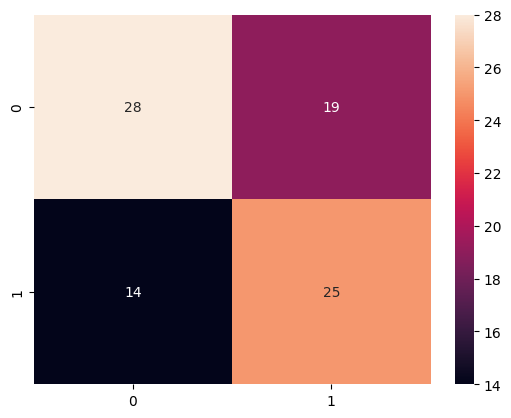

In [230]:
target_1 = df_1['STATUS'].to_numpy()
data_1 = df_1.drop(columns=['STATUS']).to_numpy()

NaiveBayes(data_1, target_1)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.50      0.02      0.04        47
         1.0       0.45      0.97      0.62        39

    accuracy                           0.45        86
   macro avg       0.48      0.50      0.33        86
weighted avg       0.48      0.45      0.30        86


Confusion Matrix:



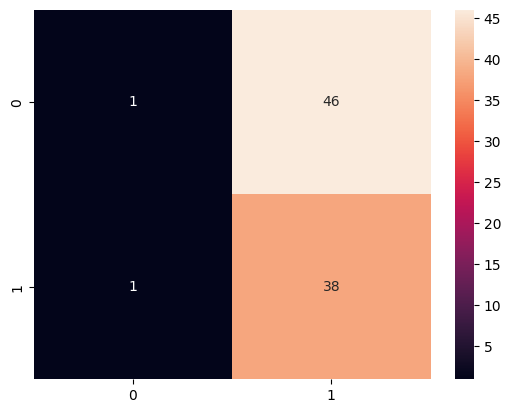

In [231]:
target_2 = df_2['STATUS'].to_numpy()
data_2 = df_2.drop(columns=['STATUS']).to_numpy()
NaiveBayes(data_2, target_2)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84        47
         1.0       0.80      0.82      0.81        39

    accuracy                           0.83        86
   macro avg       0.82      0.83      0.82        86
weighted avg       0.83      0.83      0.83        86


Confusion Matrix:



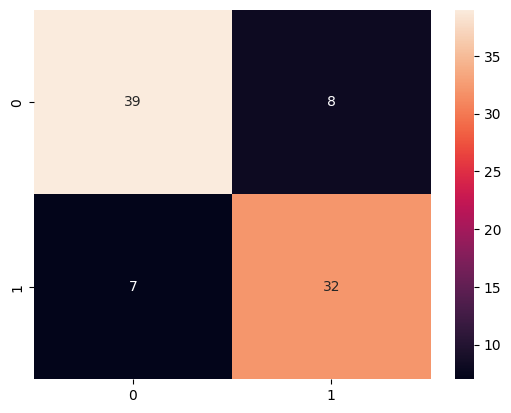

In [232]:
target_3 = df_3['STATUS'].to_numpy()
data_3 = df_3.drop(columns=['STATUS']).to_numpy()
NaiveBayes(data_3, target_3)


Classification Report:

               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88        47
         1.0       0.87      0.85      0.86        39

    accuracy                           0.87        86
   macro avg       0.87      0.87      0.87        86
weighted avg       0.87      0.87      0.87        86


Confusion Matrix:



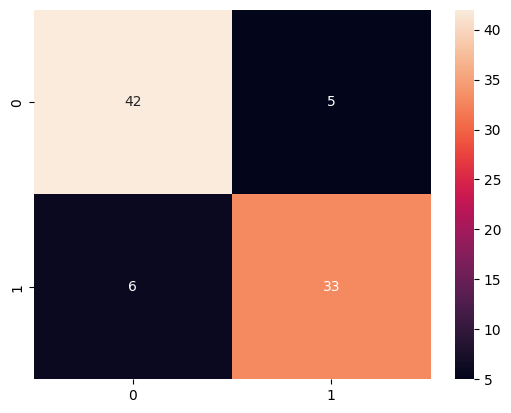

In [233]:
target_4 = df_4['STATUS'].to_numpy()
data_4 = df_4.drop(columns=['STATUS']).to_numpy()
NaiveBayes(data_4, target_4)

## Although the final dataset (hrs [54,60,66]) have the best predictions for the status of the storm at hr 78, the third dataset (hrs [36, 42, 48]) comes close in accuracy with only a 4% difference. Based on the Naive Bayes Classifier, I would say the third dataset, ([36, 42, 48]) is the better for real-world use becasue it is similar in terms of predicting accuracy, and it is 18 hours earlier than the final dataset, allowing earlier notice whether the storm is a tropical storm=0, or a hurricane=1


# LogisticRegression df_1, df_2, df_3, df_4

In [184]:
from sklearn.model_selection import GridSearchCV

In [185]:
def LogisticReg(data, target):

    trainX, testX, trainY, testY = train_test_split(data, target, test_size = 0.25, random_state=24)

    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    # init the logistic regression model
    logreg = LogisticRegression(max_iter=10000, solver='liblinear', random_state=24)

    # init GridSearchCV
    model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')

    model.fit(trainX, trainY)

    print("Best parameters:", model.best_params_)

    # use best model to predict
    best_model = model.best_estimator_
    predictedY = best_model.predict(testX)

    # print quality metrics
    print('\nClassification Report:\n\n', classification_report(testY, predictedY))
    print('\nConfusion Matrix:\n')
    sn.heatmap(confusion_matrix(testY, predictedY), annot=True)

Best parameters: {'C': 1, 'penalty': 'l1'}

Classification Report:

               precision    recall  f1-score   support

         0.0       0.58      0.85      0.69        47
         1.0       0.59      0.26      0.36        39

    accuracy                           0.58        86
   macro avg       0.58      0.55      0.52        86
weighted avg       0.58      0.58      0.54        86


Confusion Matrix:



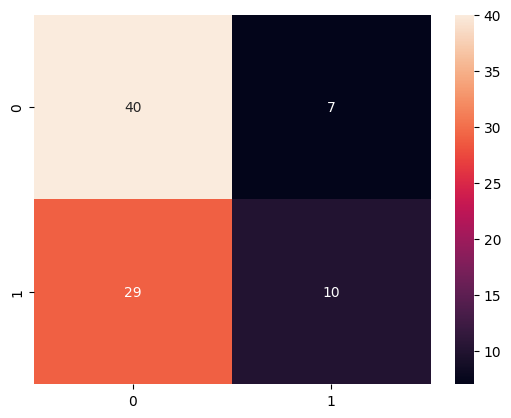

In [186]:
LogisticReg(data_1, target_1)

Best parameters: {'C': 1, 'penalty': 'l1'}

Classification Report:

               precision    recall  f1-score   support

         0.0       0.73      0.94      0.82        47
         1.0       0.88      0.59      0.71        39

    accuracy                           0.78        86
   macro avg       0.81      0.76      0.77        86
weighted avg       0.80      0.78      0.77        86


Confusion Matrix:



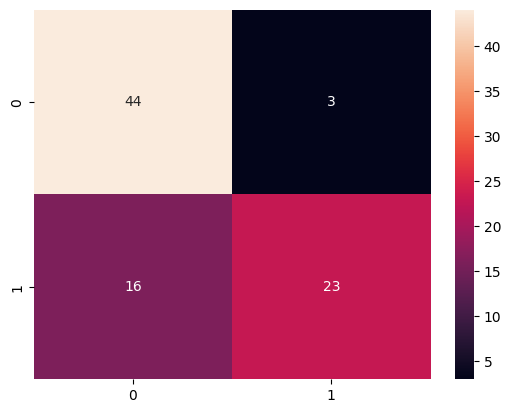

In [187]:
LogisticReg(data_2, target_2)

Best parameters: {'C': 100, 'penalty': 'l1'}

Classification Report:

               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91        47
         1.0       0.94      0.82      0.88        39

    accuracy                           0.90        86
   macro avg       0.90      0.89      0.89        86
weighted avg       0.90      0.90      0.89        86


Confusion Matrix:



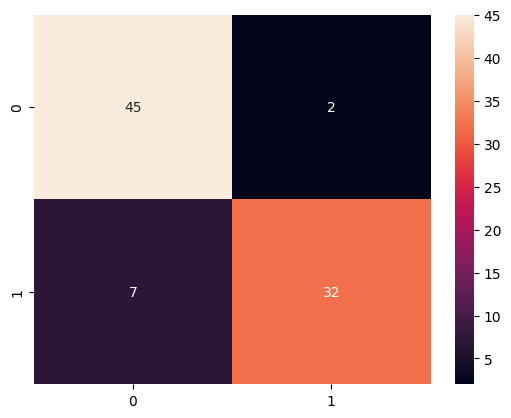

In [188]:
LogisticReg(data_3, target_3)

Best parameters: {'C': 0.01, 'penalty': 'l2'}

Classification Report:

               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        47
         1.0       0.92      0.85      0.88        39

    accuracy                           0.90        86
   macro avg       0.90      0.89      0.89        86
weighted avg       0.90      0.90      0.89        86


Confusion Matrix:



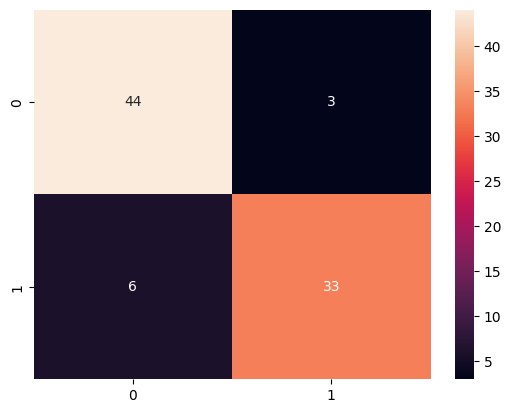

In [189]:
LogisticReg(data_4, target_4)

## The first dataset (hrs [0,6,12]) had a very bad outcome, but it is expected, as there are 66 hours of readings in between the 12th hour and the 78th hour. The second dataset (hrs [18,24,30]) surprised me with a 78% accuracy, which was not really expected due to the 2-day gap in time from hr 30-78. This is promising, as a 2-day warning on storm status could be very useful. The final dataset (hrs [54,60,66]) and the third dataset (hrs [36, 42, 48]) have the best predictions for the status of the storm at hr 78 with a tie in accuracy of 90%. Based on the tuned Logistic Regression Classifier (tuned the C value and regularization params), I would say the third dataset, ([36, 42, 48]) is the better for real-world use becasue it is equal in terms of predicting accuracy, and it is 18 hours earlier than the final dataset, allowing earlier notice whether the storm is a tropical storm=0, or a hurricane=1.


# Untuned Decision Tree df_1, df_2, df_3, df_4

In [190]:
from sklearn.tree import DecisionTreeClassifier

In [191]:
def DecisTree(data, target):
    
    trainX, testX, trainY, testY = train_test_split(data, target, test_size = 0.25, random_state=24)

    clf = DecisionTreeClassifier(random_state=24).fit(trainX, trainY)

    predictedY = clf.predict(trainX)
    print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))
    # predict the labels of the test set
    predictedY = clf.predict(testX)

    # print quality metrics
    print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
    sn.heatmap(confusion_matrix(testY, predictedY), annot=True)
    plt.figure()


Training Classification Report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.59      0.77      0.67        47
         1.0       0.56      0.36      0.44        39

    accuracy                           0.58        86
   macro avg       0.58      0.56      0.55        86
weighted avg       0.58      0.58      0.56        86



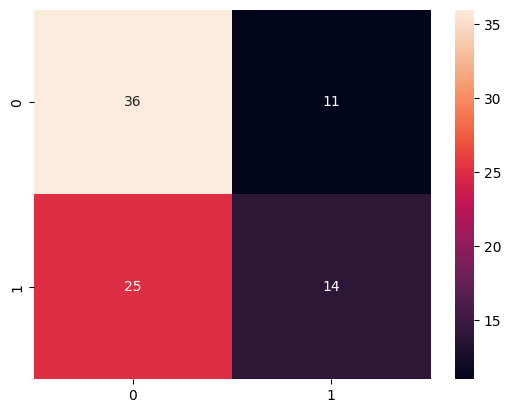

<Figure size 640x480 with 0 Axes>

In [192]:
DecisTree(data_1, target_1)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.67      0.74      0.71        47
         1.0       0.65      0.56      0.60        39

    accuracy                           0.66        86
   macro avg       0.66      0.65      0.65        86
weighted avg       0.66      0.66      0.66        86



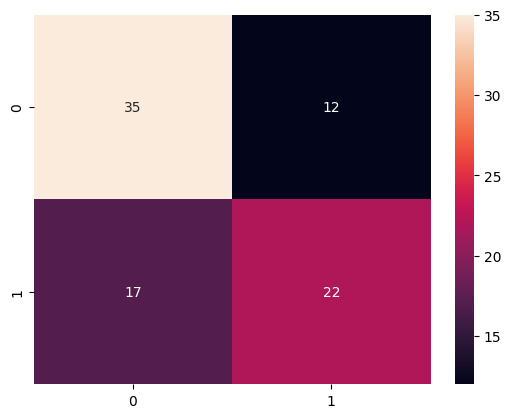

<Figure size 640x480 with 0 Axes>

In [193]:
DecisTree(data_2, target_2)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.82      0.79      0.80        47
         1.0       0.76      0.79      0.78        39

    accuracy                           0.79        86
   macro avg       0.79      0.79      0.79        86
weighted avg       0.79      0.79      0.79        86



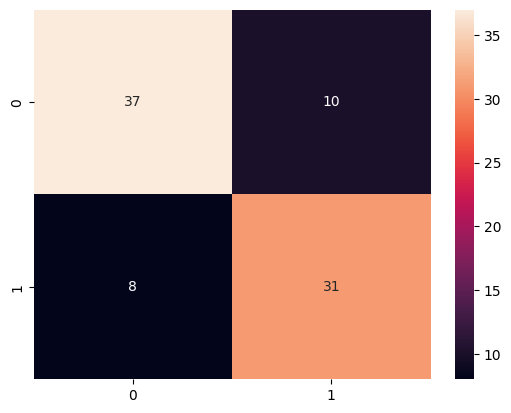

<Figure size 640x480 with 0 Axes>

In [194]:
DecisTree(data_3, target_3)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.79      0.89      0.84        47
         1.0       0.85      0.72      0.78        39

    accuracy                           0.81        86
   macro avg       0.82      0.81      0.81        86
weighted avg       0.82      0.81      0.81        86



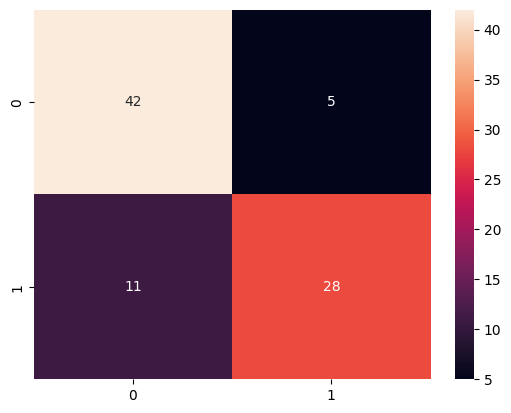

<Figure size 640x480 with 0 Axes>

In [196]:
DecisTree(data_4, target_4)

## Like the Naive Bayes Classifier, the final dataset (hrs [54,60,66]) has the best predictions for the status of the storm at hr 78, the third dataset (hrs [36, 42, 48]) comes close in accuracy with only a 2% difference. Based on the untuned Decision Tree, I would say the third dataset, ([36, 42, 48]) is the better for real-world use becasue it is similar in terms of predicting accuracy, and it is 18 hours earlier than the final dataset, allowing more early notice whether the storm is a tropical storm=0, or a hurricane=1. The first two datasets performed poorly, with a 58% accuracy and a 66% accuracy.


# Decision Tree with Cost-Complexity Pruning df_1, df_2, df_3, df_4

In [197]:
def ccp_DecisTree(data, target):    
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=24)

    # create the classifier
    clf = DecisionTreeClassifier(random_state=24)

    # do cost-complexity pruning
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    # plotting the impurities for different alphas
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]))

    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    test_scores = [clf.score(X_test, y_test) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    plt.show()
    return X_train, X_test, y_train, y_test

In [198]:
def DecisTree_ccp_alpha(trainX, trainY, testX, testY, alpha):
    
    clf = DecisionTreeClassifier(random_state=24, ccp_alpha=alpha).fit(trainX, trainY)

    predictedY = clf.predict(trainX)
    print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))
    # predict the labels of the test set
    predictedY = clf.predict(testX)

    # print quality metrics
    print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))
    sn.heatmap(confusion_matrix(testY, predictedY), annot=True)
    plt.figure()


Number of nodes in the last tree is: 1 with ccp_alpha: 0.05714977792739667


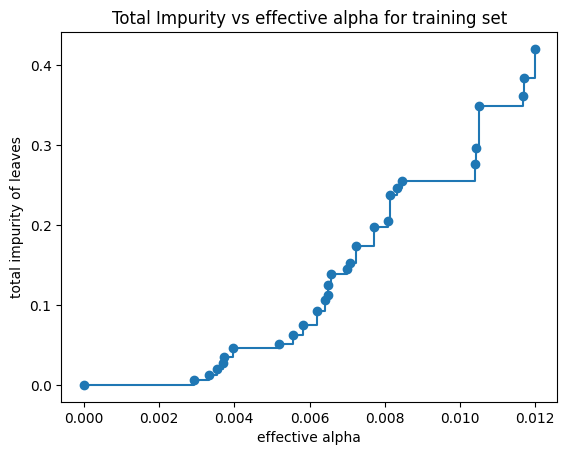

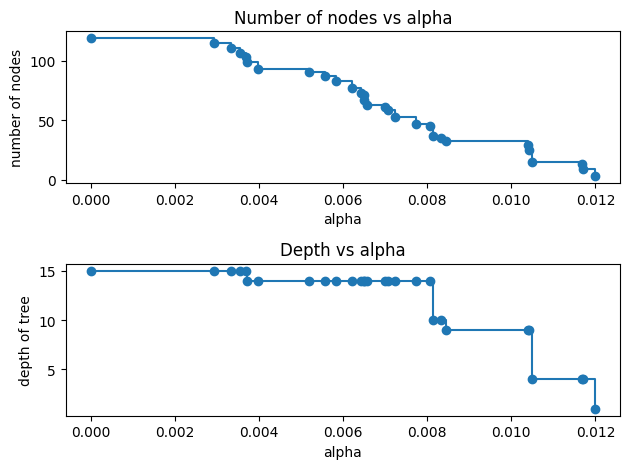

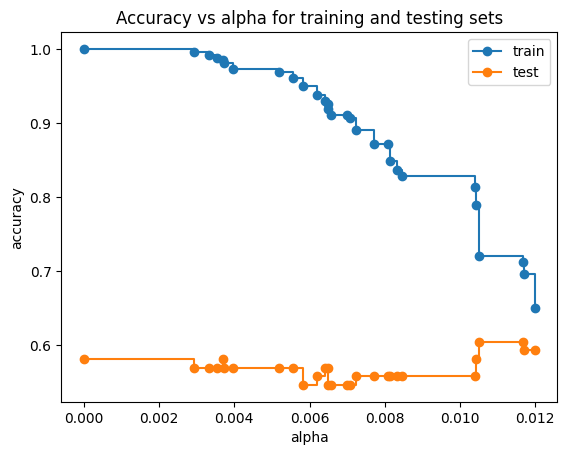

In [199]:
X_train, X_test, y_train, y_test = ccp_DecisTree(data_1, target_1)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       0.81      0.56      0.66       156
         1.0       0.54      0.79      0.64       101

    accuracy                           0.65       257
   macro avg       0.67      0.67      0.65       257
weighted avg       0.70      0.65      0.65       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.65      0.55      0.60        47
         1.0       0.54      0.64      0.59        39

    accuracy                           0.59        86
   macro avg       0.60      0.60      0.59        86
weighted avg       0.60      0.59      0.59        86



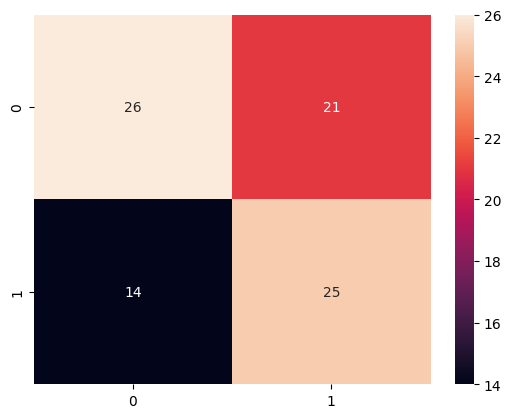

<Figure size 640x480 with 0 Axes>

In [200]:
DecisTree_ccp_alpha(X_train, y_train, X_test, y_test, 0.012)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11185949932830819


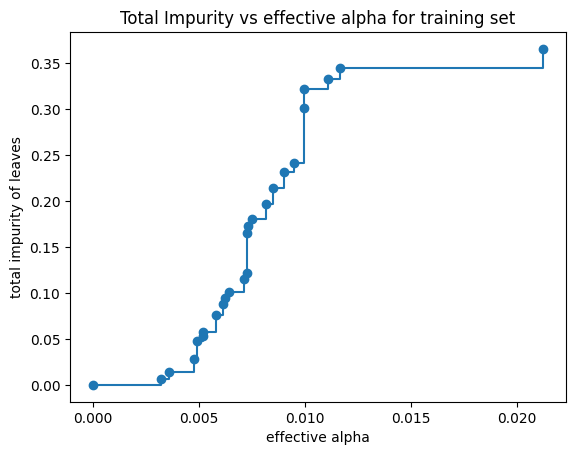

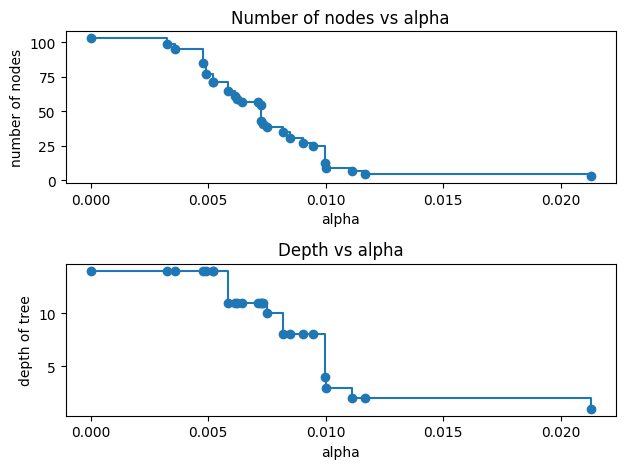

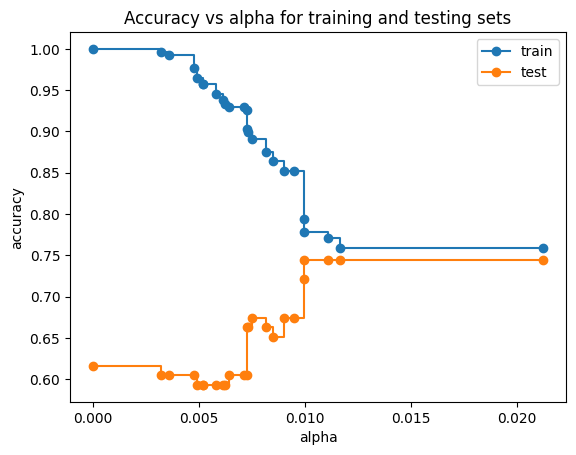

In [201]:
X_train, X_test, y_train, y_test = ccp_DecisTree(data_2, target_2)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       156
         1.0       0.78      0.61      0.69       101

    accuracy                           0.78       257
   macro avg       0.78      0.75      0.76       257
weighted avg       0.78      0.78      0.77       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.70      0.94      0.80        47
         1.0       0.87      0.51      0.65        39

    accuracy                           0.74        86
   macro avg       0.78      0.72      0.72        86
weighted avg       0.78      0.74      0.73        86



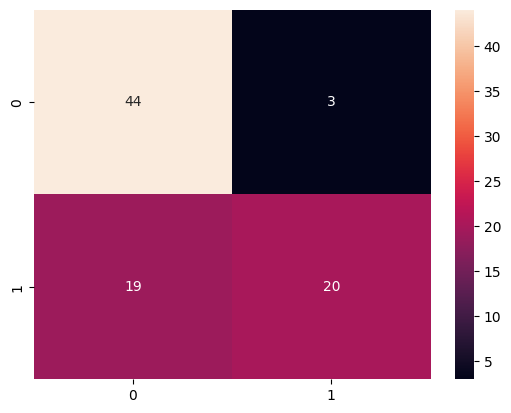

<Figure size 640x480 with 0 Axes>

In [202]:
DecisTree_ccp_alpha(X_train, y_train, X_test, y_test, 0.01)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2652158134087475


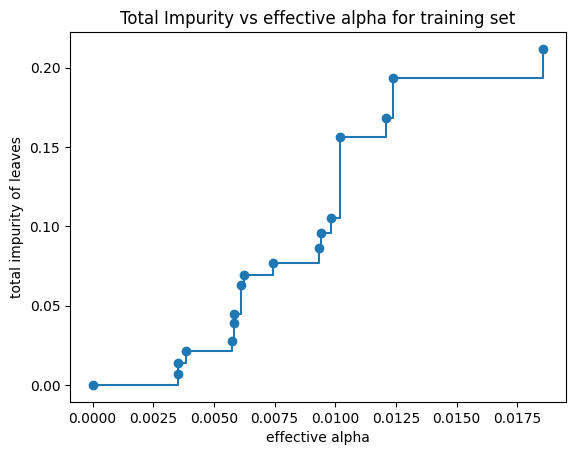

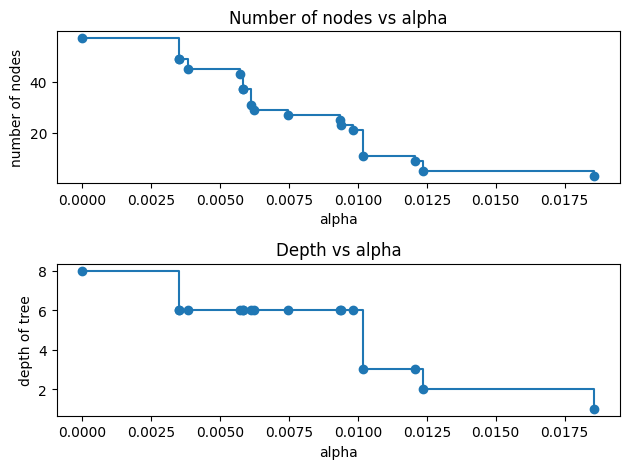

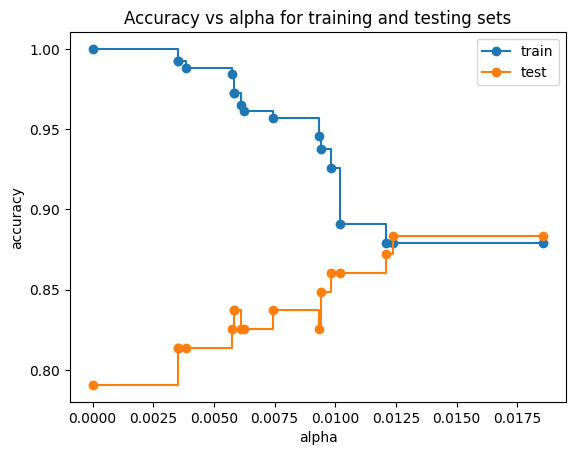

In [203]:
X_train, X_test, y_train, y_test = ccp_DecisTree(data_3, target_3)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90       156
         1.0       0.90      0.78      0.84       101

    accuracy                           0.88       257
   macro avg       0.88      0.86      0.87       257
weighted avg       0.88      0.88      0.88       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        47
         1.0       0.91      0.79      0.85        39

    accuracy                           0.87        86
   macro avg       0.88      0.87      0.87        86
weighted avg       0.88      0.87      0.87        86



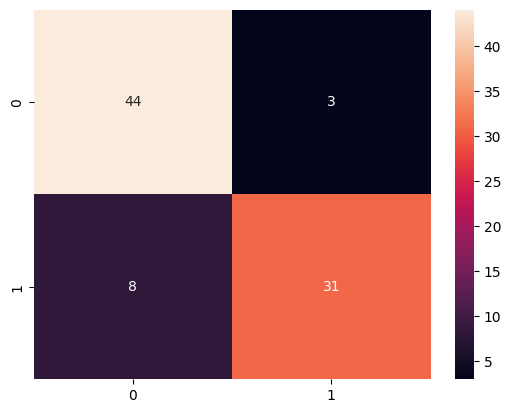

<Figure size 640x480 with 0 Axes>

In [204]:
DecisTree_ccp_alpha(X_train, y_train, X_test, y_test, 0.0122)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3444301883668328


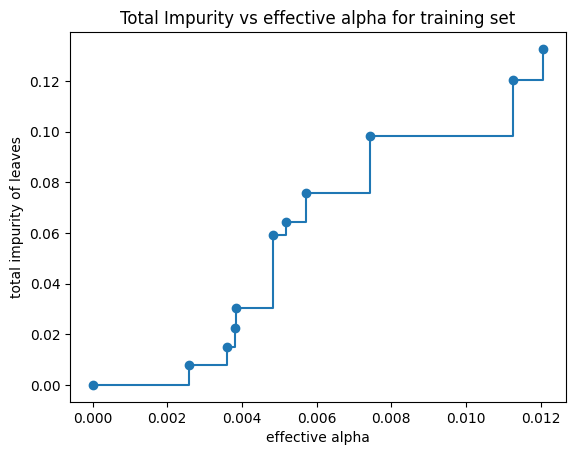

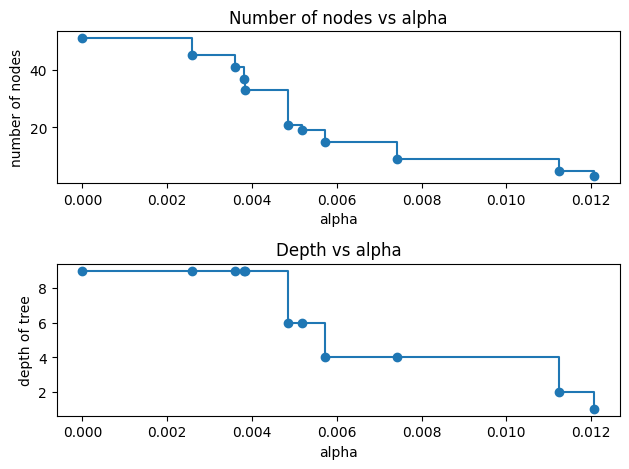

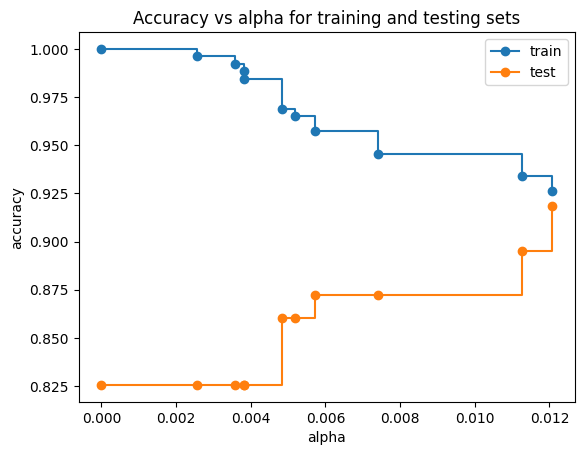

In [205]:
X_train, X_test, y_train, y_test = ccp_DecisTree(data_4, target_4)


Training Classification Report:

               precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       156
         1.0       0.89      0.95      0.92       101

    accuracy                           0.93       257
   macro avg       0.93      0.94      0.93       257
weighted avg       0.94      0.93      0.93       257


Testing Classification Report:

               precision    recall  f1-score   support

         0.0       0.90      0.91      0.91        47
         1.0       0.89      0.87      0.88        39

    accuracy                           0.90        86
   macro avg       0.90      0.89      0.89        86
weighted avg       0.90      0.90      0.90        86



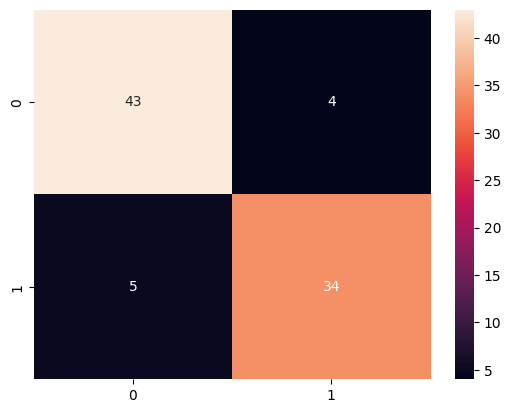

<Figure size 640x480 with 0 Axes>

In [206]:
DecisTree_ccp_alpha(X_train, y_train, X_test, y_test, 0.012)

## After introducing Cost Complexity Pruning to the decision tree to simplify the trees, there was a moderate jump in accuracy for datasets 2, 3, and 4. Like the other models, dataset one performed poorly, with only a 1% jump in accuracy from the untuned decision tree. The second dataset had an 8% jump in accuracy to get it to 74% accuracy. The third and fourth datasets had 8% and 9% gains in accuracy to boost them to 87% and 90% accuracies in predicting whether the storm is a tropical storm or hurrincane in the 78th hour

# XGBoost for df_1, df_2, df_3, df_4

In [207]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [208]:
def XGBoost(data, target):
    trainX, testX, trainY, testY = train_test_split(data, target, test_size = 0.25, random_state=24)
    valX, testX, valY, testY = train_test_split(testX, testY, test_size = 0.5, random_state=24)

    parameters = {'max_depth': [1, 5, 10, 100, None], 'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
    model = GridSearchCV(XGBClassifier(n_jobs = -1, eval_metric='logloss', random_state=24), parameters, n_jobs = -1)
    print(len(valX), len(valY))
    # fit the classifier to the training data
    model.fit(trainX, trainY, eval_set = [(valX, valY)])

    # predict the labels of the training set
    predictedY = model.predict(trainX)

    # print quality metrics
    print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

    # predict the labels of the test set
    predictedY = model.predict(testX)

    # print quality metrics
    print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

    # predict the labels of the test set
    predictedY = model.predict(testX)

    print('\nTesting Confusion Matrix:\n')

    sn.heatmap(confusion_matrix(testY, predictedY), annot=True)
    plt.figure()

43 43
[0]	validation_0-logloss:0.65756
[1]	validation_0-logloss:0.65402
[2]	validation_0-logloss:0.65424
[3]	validation_0-logloss:0.65794
[4]	validation_0-logloss:0.66018
[5]	validation_0-logloss:0.66493
[6]	validation_0-logloss:0.66273
[7]	validation_0-logloss:0.65889
[8]	validation_0-logloss:0.66398
[9]	validation_0-logloss:0.66315
[10]	validation_0-logloss:0.67106
[11]	validation_0-logloss:0.66944
[12]	validation_0-logloss:0.66705
[13]	validation_0-logloss:0.67163
[14]	validation_0-logloss:0.67512
[15]	validation_0-logloss:0.68012
[16]	validation_0-logloss:0.68316
[17]	validation_0-logloss:0.68660
[18]	validation_0-logloss:0.68590
[19]	validation_0-logloss:0.68980
[20]	validation_0-logloss:0.68673
[21]	validation_0-logloss:0.68597
[22]	validation_0-logloss:0.68477
[23]	validation_0-logloss:0.68719
[24]	validation_0-logloss:0.68495
[25]	validation_0-logloss:0.68814
[26]	validation_0-logloss:0.69055
[27]	validation_0-logloss:0.69032
[28]	validation_0-logloss:0.69073
[29]	validation_0-

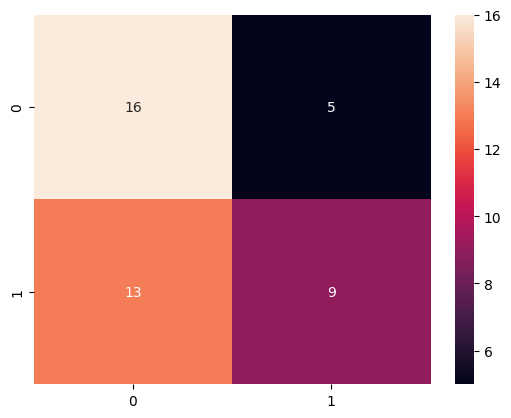

<Figure size 640x480 with 0 Axes>

In [210]:
XGBoost(data_1, target_1)

43 43
[0]	validation_0-logloss:0.62834
[1]	validation_0-logloss:0.61364
[2]	validation_0-logloss:0.58625
[3]	validation_0-logloss:0.56683
[4]	validation_0-logloss:0.56144
[5]	validation_0-logloss:0.55484
[6]	validation_0-logloss:0.54676
[7]	validation_0-logloss:0.54848
[8]	validation_0-logloss:0.55301
[9]	validation_0-logloss:0.54888
[10]	validation_0-logloss:0.55074
[11]	validation_0-logloss:0.55199
[12]	validation_0-logloss:0.55405
[13]	validation_0-logloss:0.55209
[14]	validation_0-logloss:0.54756
[15]	validation_0-logloss:0.54678
[16]	validation_0-logloss:0.54832
[17]	validation_0-logloss:0.55077
[18]	validation_0-logloss:0.54908
[19]	validation_0-logloss:0.54855
[20]	validation_0-logloss:0.55010
[21]	validation_0-logloss:0.55264
[22]	validation_0-logloss:0.55140
[23]	validation_0-logloss:0.55075
[24]	validation_0-logloss:0.55364
[25]	validation_0-logloss:0.55614
[26]	validation_0-logloss:0.55521
[27]	validation_0-logloss:0.55732
[28]	validation_0-logloss:0.55634
[29]	validation_0-

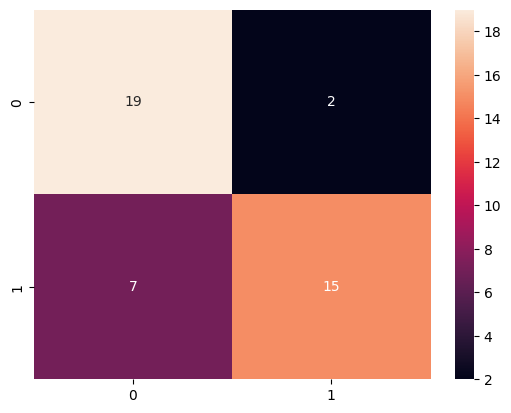

<Figure size 640x480 with 0 Axes>

In [211]:
XGBoost(data_2, target_2)

43 43
[0]	validation_0-logloss:0.47504
[1]	validation_0-logloss:0.37501
[2]	validation_0-logloss:0.29899
[3]	validation_0-logloss:0.26101
[4]	validation_0-logloss:0.22537
[5]	validation_0-logloss:0.21204
[6]	validation_0-logloss:0.19008
[7]	validation_0-logloss:0.18400
[8]	validation_0-logloss:0.18006
[9]	validation_0-logloss:0.17228
[10]	validation_0-logloss:0.17230
[11]	validation_0-logloss:0.16840
[12]	validation_0-logloss:0.16735
[13]	validation_0-logloss:0.16827
[14]	validation_0-logloss:0.16241
[15]	validation_0-logloss:0.15515
[16]	validation_0-logloss:0.15801
[17]	validation_0-logloss:0.15420
[18]	validation_0-logloss:0.14691
[19]	validation_0-logloss:0.14407
[20]	validation_0-logloss:0.14944
[21]	validation_0-logloss:0.15076
[22]	validation_0-logloss:0.15246
[23]	validation_0-logloss:0.15853
[24]	validation_0-logloss:0.15763
[25]	validation_0-logloss:0.15359
[26]	validation_0-logloss:0.15549
[27]	validation_0-logloss:0.15944
[28]	validation_0-logloss:0.15825
[29]	validation_0-

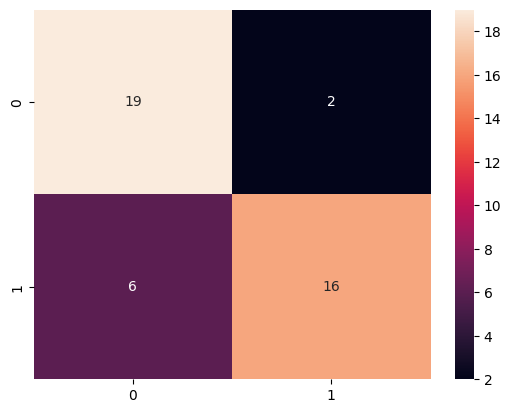

<Figure size 640x480 with 0 Axes>

In [212]:
XGBoost(data_3, target_3)

43 43
[0]	validation_0-logloss:0.47142
[1]	validation_0-logloss:0.37111
[2]	validation_0-logloss:0.30339
[3]	validation_0-logloss:0.26290
[4]	validation_0-logloss:0.23688
[5]	validation_0-logloss:0.22703
[6]	validation_0-logloss:0.21491
[7]	validation_0-logloss:0.20277
[8]	validation_0-logloss:0.19791
[9]	validation_0-logloss:0.19104
[10]	validation_0-logloss:0.18433
[11]	validation_0-logloss:0.17593
[12]	validation_0-logloss:0.17796
[13]	validation_0-logloss:0.17411
[14]	validation_0-logloss:0.17370
[15]	validation_0-logloss:0.17598
[16]	validation_0-logloss:0.17809
[17]	validation_0-logloss:0.17593
[18]	validation_0-logloss:0.17622
[19]	validation_0-logloss:0.17297
[20]	validation_0-logloss:0.17461
[21]	validation_0-logloss:0.16996
[22]	validation_0-logloss:0.17025
[23]	validation_0-logloss:0.16846
[24]	validation_0-logloss:0.17028
[25]	validation_0-logloss:0.17646
[26]	validation_0-logloss:0.17140
[27]	validation_0-logloss:0.16977
[28]	validation_0-logloss:0.16996
[29]	validation_0-

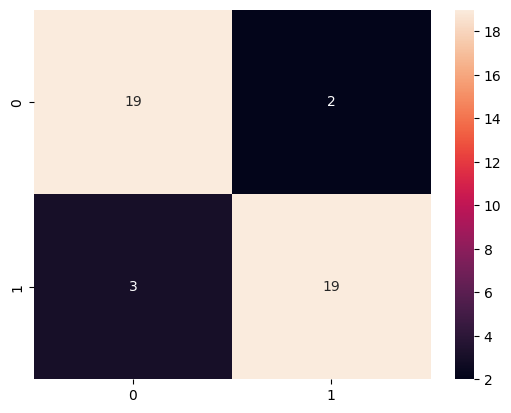

<Figure size 640x480 with 0 Axes>

In [213]:
XGBoost(data_4, target_4)

## In this tuned XGBoost implementation, dataset 1 performed poorly with an accuracy of 58%, dataset 2 with an accuracy of 79%, dataset 3 with an accuracy of 81%, and dataset 4 with an accuracy of 88%. The model using dataset 2 surprised me, with a 2% difference to the model using dataset 3. That being said, the accuracy gap from models 3 and 4 is too large to conclude that dataset 2 or 3 is more useful than dataset 4, as ~90% is better than ~80%.

# Random Forest df_1, df_2, df_3, df_4

In [214]:
from sklearn.ensemble import RandomForestClassifier

In [221]:
def RandomForestTuned(data, target):
    
    trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.25, random_state=24)
    
    param_grid = {
        'n_estimators': [10, 50, 100, 500],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],     # Maximum depth of the tree
        'max_features': ['sqrt', None]  # Number of features to consider at every split
    }
    
    # init the grid search model
    model = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=24),
                               param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    model.fit(trainX, trainY)
    
    print(f"Best parameters found: {model.best_params_}")
    print(f"Best cross-validation score: {model.best_score_:.2f}")
    
    # use best model to make predictions
    best_model = model.best_estimator_
    
    # Predict on training set
    train_pred = best_model.predict(trainX)
    print('\nTraining Classification Report:\n', classification_report(trainY, train_pred))
    
    # Predict on test set
    test_pred = best_model.predict(testX)
    print('\nTesting Classification Report:\n', classification_report(testY, test_pred))
    
    # Confusion Matrix
    print('\nTesting Confusion Matrix:\n')
    sn.heatmap(confusion_matrix(testY, test_pred), annot=True)
    plt.show()

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score: 0.67

Training Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.79      0.66        47
         1.0       0.52      0.28      0.37        39

    accuracy                           0.56        86
   macro avg       0.55      0.53      0.51        86
weighted avg       0.55      0.56      0.53        86


Testing Confusion Matrix:



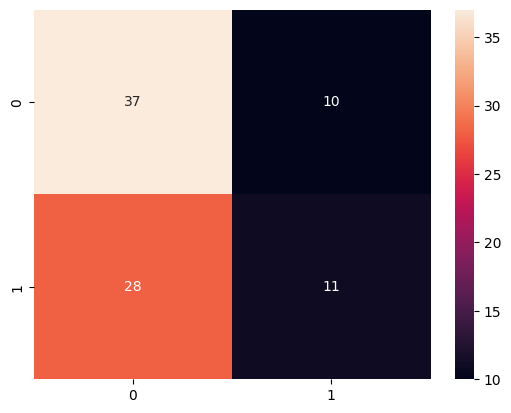

In [222]:
RandomForestTuned(data_1, target_1)

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Best cross-validation score: 0.77

Training Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.87      0.79        47
         1.0       0.79      0.59      0.68        39

    accuracy                           0.74        86
   macro avg       0.76      0.73      0.73        86
weighted avg       0.75      0.74      0.74        86


Testing Confusion Matrix:



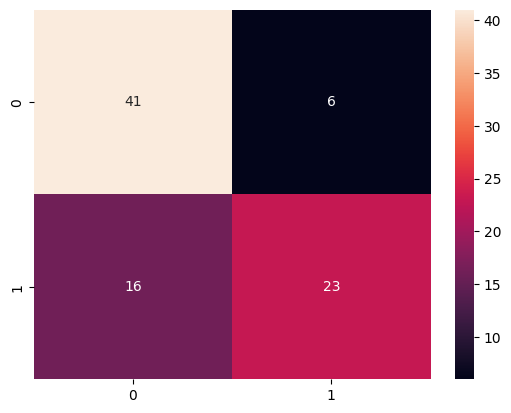

In [223]:
RandomForestTuned(data_2, target_2)

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Best cross-validation score: 0.88

Training Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       156
         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.98      0.90        47
         1.0       0.97      0.77      0.86        39

    accuracy                           0.88        86
   macro avg       0.90      0.87      0.88        86
weighted avg       0.90      0.88      0.88        86


Testing Confusion Matrix:



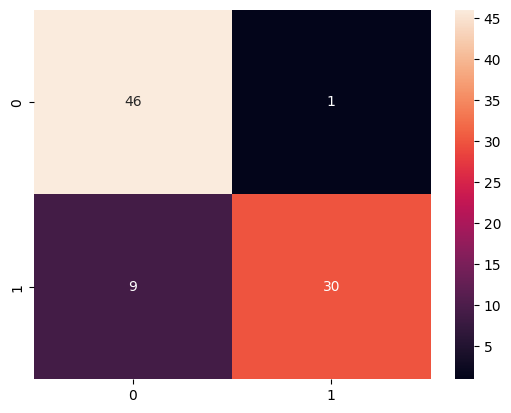

In [224]:
RandomForestTuned(data_3, target_3)

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}
Best cross-validation score: 0.91

Training Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       156
         1.0       1.00      0.99      1.00       101

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        47
         1.0       0.91      0.82      0.86        39

    accuracy                           0.88        86
   macro avg       0.89      0.88      0.88        86
weighted avg       0.89      0.88      0.88        86


Testing Confusion Matrix:



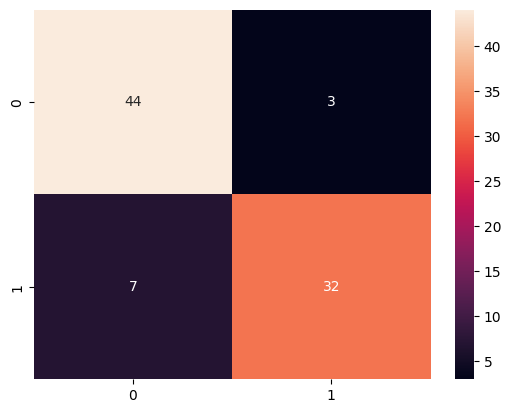

In [226]:
RandomForestTuned(data_4, target_4)

## For this implementation of tuned Random Forests, I tuned the hyperparameters for the number of trees in the Forest, the max depth of the trees, and the max features considered at each split. Like all other models, dataset 1 performed the worst with a 56% accuracy. Dataset 2 performed well with a 74% accuracy, and datasets 3 and 4 both had 88% accuracies. The model that is the best at predicting trop storm or hurr in the 78th hour using dataset 3 (hrs [36, 42, 48]) because it is equivalent in overall accuracy to dataset 4, and the earlier chunk gets more overall weight because the initial goal was to find the minimum needed to predict the 78th hour.

# My decision to include XGBoost and Random Forests was to compare the performance of the boosted vs bagged models. They had similar performances, but XGBoost was better with dataset 2 [18,24,30] and Random Forest was better with dataset 3 [36,42,48]. Given the untuned Decision Tree performed reasonably well, I figured sticking to models using decision trees would provide similarly good results. I was somewhat surprised the bagged and boosted models had roughly equivalent performances to each other and the Decision Tree with Cost Complexity Pruning, as I expected it XGBoost to be better than both.

# Overall Findings:

## The main challenges I found in this project were issues with the dataset. The main predictors for storm categories are wind readings, but this dataset was missing the majority of the wind features were missing data, except for the max windspeed in knots. Due to this, I had to slightly shift my goal to predicting storm types. Also, the minimum pressure column was not introduced until 1975, so I filtered the data to get storms after that year. Because there was so much missing data, I had to cut the dataset down significantly to get clean, usable data. For example, of the 9 storm types found in the base dataset, there was only enough data in the tropical storm and hurricane catetgories, so I was forced to drop all categories except those two. Too combat this massive loss in data, I added distance columns indicating the distance from readings 0->1 and 1->2. Also, I used an API from https://ocean.amentum.io to get ocean depth and salinity from the coordinates of the readings. This particular API was quite slow, with the ~5000 API calls taking around 4 hours to get the data. Becuase of the time taken to run the API calls, I saved the dataset with the remaining features from the dataset, now also including salinity, depth, and distance between readings to a txt file for ease of use. Likewise, the main challenges I found in the models were also due to the constraints of the dataset because of the lack of size after preprocessing the data. There was a relatively good balance between tropical storms and hurricanes present in the data, but it lacked the size to produce truly dependable models.

| Model                         | df_1 (acc) | df_2 (acc) | df_3 (acc) | df_4 (acc) |
|-------------------------------|------------|------------|------------|------------|
| Naive Bayes                   | .62        | .45        | .83        | .87        |
| Logistic Regression (tuned)   | .58        | .78        | .90        | .90        |
| Decision Tree                 | .58        | .66        | .79        | .81        |
| Decision Tree (ccp)           | .59        | .74        | .87        | .90        |
| XGBoost (tuned)               | .58        | .79        | .81        | .88        |
| Random Forest (tuned)         | .56        | .74        | .88        | .88        |


| Dataset | Accuracy Average |
|---------|------------------|
| df_1    | .59              |
| df_2    | .69              |
| df_3    | .85              |
| df_4    | .87              |


### The tuned models (Logistic Regression, Decision Tree with CCP, XGBoost, and Random Forest) all performed better on models with datasets 2-4 than the basic, benchmark models (Naive Bayes and basic Decision Tree). Dataset 1 performed poorly across all models, which is somewhat expected, as 66 hours is a large amount of time to predict ahead given such little data. Datasets 2, 3, and 4 all improved their accuracies from a basic Decision Tree to the Decision Tree with Cost Complexity Pruning, XGBoost, and Random Forest.

### Given the accuracies, the best model across all 4 datasets was the tuned Logistic Regression model, and the worst model was the Naive Bayes Classifier.


### The average accuracies of models using the four datasets do not mean too much, they just help show the similarities between the performance of models with dataset 3 and dataset 4. 



## Initial Goal: Finding the minimum number of hours needed to predict whether a storm is a hurricane or tropical storm on hour 78.

# Given all the performance data, I conclude that with this dataset, the minimum amount of time needed to predict whether a storm is a tropical storm or hurricane in the 78th hour is 30 hours (dataset 3 = hrs [36, 42, 48]) because the performance was extremely close to dataset 4 (hrs [54, 60, 66]), and it is 18 hours earlier. My thresholds for similarity in accuracy between datasets was ~5% and the minimum accuracy was 75%, so preference was given to a model using an earlier dataset performed within 5% of difference in accuracy to a model using a dataset with later readings. 